# Sentiment Analysis

In [ ]:
!pip install spacy==2.2.3
!python -m spacy download pt

In [2]:
import pandas as pd
import numpy as np
import string
import spacy
import random
import seaborn as sns

## Load TXT File

In [3]:
data = pd.read_csv("base_treinamento.txt")
data.shape

(196, 2)

In [4]:
data.sample(5)

,texto,emocao
165,vou apanhar se meus pais verem meu boletim,medo
185,receio que terei de ir,medo
145,acho que está arriscado de mais,medo
56,adoro este doce de frutas,alegria
90,muito bem esta tudo em ordem agora,alegria


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


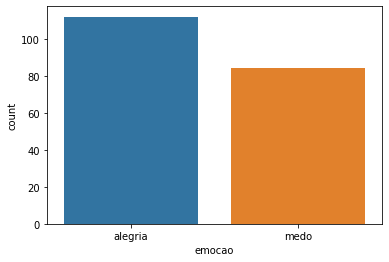

In [5]:
sns.countplot(data['emocao'], label = 'Count')

## Text Preprocessing

In [6]:
punc = string.punctuation
punc

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop_words = STOP_WORDS
stop_words

In [8]:
pln = spacy.load('pt')

In [9]:
def preprocessing(text):
  text = text.lower()
  doc = pln(text)
  token_list = []
  for token in doc:
    token_list.append(token.lemma_)
  
  token_list = [token for token in token_list if token not in stop_words and token not in punc]
  token_list = " ".join([str (token) for token in token_list if not token.isdigit()])

  return token_list

In [10]:
data["texto"] = data["texto"].apply(preprocessing)

In [11]:
data.sample(5)

,texto,emocao
9,querer agradar filho,alegria
14,achar apaixonar,alegria
35,umar festa parir comemorar aniversário,alegria
41,cativar pelar olhar,alegria
56,adorar doce frutar,alegria


## Class Processing

In [12]:
final_data = []
for text, emotion in zip(data["texto"], data["emocao"]):
  dic = {}
  if (emotion == "alegria"):
    dic = {"HAPPINESS": True, "FEAR": False}
  else:
    dic = {"HAPPINESS": False, "FEAR": True}
  final_data.append([text, dic])

final_data

[['trabalhar agradável', {'FEAR': False, 'HAPPINESS': True}],
 ['gostar ficar o aconchegar', {'FEAR': False, 'HAPPINESS': True}],
 ['o adesão o o cursar hoje', {'FEAR': False, 'HAPPINESS': True}],
 ['admirar', {'FEAR': False, 'HAPPINESS': True}],
 ['adorar comer', {'FEAR': False, 'HAPPINESS': True}],
 ['adorar cabelar maciar', {'FEAR': False, 'HAPPINESS': True}],
 ['adorar o cor olho', {'FEAR': False, 'HAPPINESS': True}],
 ['somar amável o outro', {'FEAR': False, 'HAPPINESS': True}],
 ['sentir umar afeição', {'FEAR': False, 'HAPPINESS': True}],
 ['querer agradar filho', {'FEAR': False, 'HAPPINESS': True}],
 ['sentir completamente amar', {'FEAR': False, 'HAPPINESS': True}],
 ['amar', {'FEAR': False, 'HAPPINESS': True}],
 ['alívio', {'FEAR': False, 'HAPPINESS': True}],
 ['o dor amenizar finalmente', {'FEAR': False, 'HAPPINESS': True}],
 ['achar apaixonar', {'FEAR': False, 'HAPPINESS': True}],
 ['amar maravilhoso', {'FEAR': False, 'HAPPINESS': True}],
 ['sentir animar', {'FEAR': False, 'H

## Class Classifier

In [13]:
model = spacy.blank('pt')
categories = model.create_pipe("textcat")
categories.add_label("HAPPINESS")
categories.add_label("FEAR")
model.add_pipe(categories)
historic = []

In [ ]:
model.begin_training()
for epoch in range(1000):
  random.shuffle(final_data)
  losses = {}
  for batch in spacy.util.minibatch(final_data, 30):
    texts = [model(text) for text, entities in batch]
    annotations = [{'cats': entities} for text, entities in batch]
    model.update(texts, annotations, losses=losses)
  if epoch % 100 == 0:
    print(losses)
    historic.append(losses)

{'textcat': 0.00707400991814211}
{'textcat': 1.5358122329445223e-07}
{'textcat': 4.416656818051479e-08}
{'textcat': 1.9137725071338707e-08}


In [ ]:
historic_loss = []
for i in historic:
  historic_loss.append(i.get('textcat'))

In [ ]:
historic_loss = np.array(historic_loss)
historic_loss

In [ ]:
import matplotlib.pyplot as plt
plt.plot(historic_loss)
plt.title('Error Progression')
plt.xlabel('Épochs')
plt.ylabel('Error')

In [ ]:
model.to_disk("model")

## Simple Test

In [ ]:
loaded_model = spacy.load("model")
loaded_model

In [ ]:
positive_text = 'eu adoro a cor dos seus olhos'
positive_text = preprocessing(positive_text)
prevision = loaded_model(positive_text)
prevision.cats

In [ ]:
negative_text = 'estou com medo de você'
negative_text = preprocessing(negative_text)
prevision = loaded_model(negative_text)
prevision.cats

## Model Valuation

### Train database valuation

In [ ]:
predictions = []
for text in data['texto']:
  prediction = loaded_model(text)
  predictions.append(prediction.cats)

In [ ]:
predictions

In [ ]:
final_predictions = []
for prediction in predictions:
  if prediction['HAPPINESS'] > prediction['FEAR']:
    final_predictions.append('alegria')
  else:
    final_predictions.append('medo')

final_predictions = np.array(final_predictions)

In [ ]:
final_predictions

In [ ]:
real = data['emocao'].values
real

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(real, final_predictions)

In [ ]:
cm = confusion_matrix(real, final_predictions)
cm

### Test database valuation

In [ ]:
test_data = pd.read_csv('/content/base_teste.txt', encoding = 'utf-8')

In [ ]:
test_data.head()

In [ ]:
test_data['texto'] = test_data['texto'].apply(preprocessing)

In [ ]:
test_data.head()

In [ ]:
predictions = []
for text in test_data['texto']:
  prediction = loaded_model(text)
  predictions.append(prediction.cats)

In [ ]:
final_predictions = []
for prediction in predictions:
  if prediction['HAPPINESS'] > prediction['FEAR']:
    final_predictions.append('alegria')
  else:
    final_predictions.append('medo')

final_predictions = np.array(final_predictions)

In [ ]:
real = test_data['emocao'].values

In [ ]:
accuracy_score(real, final_predictions)

In [ ]:
cm = confusion_matrix(real, final_predictions)
cm